### Model class

In [1]:
import sys
import numpy as np
from assimulo.solvers import CVode
from assimulo.problem import Explicit_Problem

In [2]:
class Mod1D():
    def __init__(self,N,K,PBC):

        self.T=[1]
        self.pbc=PBC

        #global
        self.n=N
        self.K=K
        self.verb=50
    
        #auxin
        self.Ga=1
        self.A=6
        self.Da=35.5
        self.Da_sym=1
        self.Da_apo=1
        
        #pin
        self.Gp=2
        self.p=40
        self.Ep=1
        
        #phi
        self.m=1.1
        
        # extracellular space
        self.Eq=1
        self.q=1
        self.V=10
    
    # show integration time progress    
    def progress(self,t,T=0):
        T=self.T[0]
        prog="\r{0:.4f}%".format(t/T*100)
        sys.stdout.write(prog+" "*(25-len(prog)))
    
    # shift array    
    def shift(self,arr,d):
        if d: out=np.array(list(arr[1:])+[arr[0]*self.pbc]) # right
        else: out=np.array([arr[-1]*self.pbc]+list(arr[:-1])) # left
        return out
    
    # PIN polarization function    
    def phi(self,aux):
        return aux**self.m
    
    # flux functions 
    def flux_aux(self,aux,apo,pinl,pinr):
        return self.Ep*aux*(pinl+pinr)-self.Eq*self.q*(self.shift(apo,0)+apo)
    
    def flux_apo(self,aux,apo,pinl,pinr):
        return 2*self.Eq*self.q*apo-self.Ep*(pinr*aux+self.shift(pinl,1)*self.shift(aux,1))
    
    # diffusion functions  
    def diff(self,aux,apo):
        return self.Da*(self.shift(apo,0)+apo-2*aux)
    
    def apodiff(self,aux,apo):
        return self.Da*(self.shift(aux,1)+aux-2*apo)
    
    # symplast duffusion
    def sym_diff(self,aux):
        return self.Da_sym*(self.shift(aux,0)+self.shift(aux,1)-2*aux)
    
    # apoplast diffusion
    def apo_diff(self,apo):
        return (self.Da_apo/self.V)*(self.shift(apo,0)+self.shift(apo,1)-2*apo)

    # ODE 
    def sim(self,time,start):
        
        # progress of integration
        self.progress(time)

        aux,apo,pinl,pinr=np.array_split(start,4)

        dta=self.Ga*(self.A-aux)-self.flux_aux(aux,apo,pinl,pinr)+self.diff(aux,apo)+self.sym_diff(aux)
        dtapo=-self.flux_apo(aux,apo,pinl,pinr)/self.V+self.apodiff(aux,apo)/self.V+self.apo_diff(apo)
        dtpl=self.Gp*(self.K*self.p*(self.phi(self.shift(apo,0))/(self.phi(self.shift(apo,0))+self.phi(apo)))-pinl)
        dtpr=self.Gp*(self.K*self.p*(self.phi(apo)/(self.phi(self.shift(apo,0))+self.phi(apo)))-pinr)

        out=np.concatenate((dta,dtapo,dtpl,dtpr))
        return out
    
    def intgr(self,time,start):
        self.T[0]=time
        
        # CVode from Assimulo                
        problem=Explicit_Problem(self.sim,start)
        sim=CVode(problem)
        sim.verbosity=self.verb
        T,res=sim.simulate(time,time)

        return [T,res]    

### Execute model

In [3]:
import itertools
import numpy as np
import pylab as plt
import random

In [4]:
# cell number
n=100

# neighbour number
k=2

# base auxin and PIN concentration
auxin=6
pin=4

# integration time
time=10000

# noise on base concentration [%]
noise=.01

# initial values
#random.seed(2356)
aux = [auxin for i in range(n)] + np.random.normal(0,auxin*noise,n)
apo = [auxin for i in range(n)] + np.random.normal(0,auxin*noise,n)
pin_left = [pin for i in range(n)] + np.random.normal(0,pin*noise,n)
pin_right = [2*pin-x for x in pin_left] + np.random.normal(0,pin*noise,n)

#set initial distribution manually (noise=0)
# i.e. aux[30]*=1.1

start=np.concatenate((aux, apo, pin_left, pin_right))

# periodic boundary condition
PBC=1

In [5]:
# class initiation
model=Mod1D(n,k,PBC)

# model parameter
model.Ga=1 # auxin degredation/synthesis coefficient to A
model.A=6 # auxin base level of synthesis (steady state)
model.Da=35.5 # auxin diffusion coefficient to equilibrium
model.Da_sym=0 # symplast diffusion coefficient (cell-cell)
model.Da_apo=0 # apoplast diffusion coefficient (apoplast-apoplast)

model.Gp=2 # pin degredation/synthesis coefficient to p
model.p=40 # pin base level of synthesis (steady state)
model.m=4 # influence of regulatory function phi
model.Ep=1 # pin efflux efficiency

model.q=10 # concentration of influx carriert on membrane side
model.Eq=1 # efficiency of influx carrier
model.V=1 # volume ratio of apoplast to cytoplast

In [6]:
# integration
T,R=model.intgr(time,start)

0.0000%                 

100.0000%               

In [43]:
R

array([[ 6.06032565,  5.92129384,  5.91146015, ...,  4.03810147,
         4.00327555,  4.04133373],
       [ 4.97953668,  4.99016028,  4.93081416, ..., 36.41462461,
        34.71740894, 35.63379072],
       [ 5.11701181,  5.25336187,  4.93104533, ..., 49.70131474,
        34.52471786, 44.1187935 ],
       ...,
       [ 7.52838449,  8.04621129,  8.25125359, ..., 79.26992164,
         0.89314279, 79.29998836],
       [ 7.52838449,  8.04621129,  8.25125359, ..., 79.26992164,
         0.89314279, 79.29998836],
       [ 7.52838449,  8.04621129,  8.25125359, ..., 79.26992164,
         0.89314279, 79.29998836]])

In [44]:
# wavelength of auxin peaks in the pattern
def wave():
    DFT=[abs(x)**2 for x in np.fft.fft(R[-1,:n])[1:int(n/2)]]
    k=list(DFT).index(max(DFT))+1
    return n/k 

wave()

14.285714285714286

In [47]:
# average width of auxin peaks in the pattern
def Pwid():
    aux=R[-1,:n]
    avg=np.average(aux)
    high=[1 if aux[i]>avg else 0 for i in range(n)]
    return np.average([sum(1 for _ in group) for key,group in itertools.groupby(high) if key])

Pwid()

4.416666666666667

In [7]:
# find steady state
def steady(thr,acc):
    state0=R[0,:n]
    window=0
    for i in range(len(R)):
        if window==thr: return i
        if (state0-R[i,:n]<=acc).all(): window+=1
        else: window=0
        state0=R[i,:n]
    return "NO"

        
steady(thr=100,acc=10**-4)

117

### Create plots

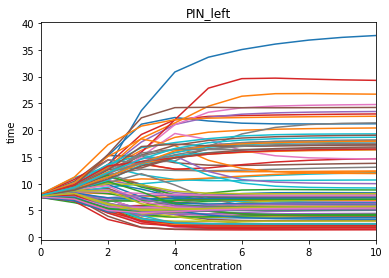

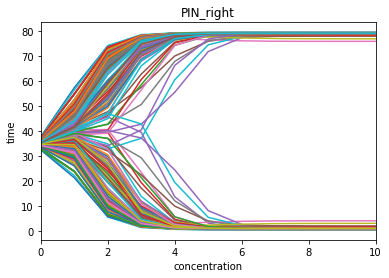

In [11]:
# concentration of auxin and PINs (both side) over time
def CT(show="100",showrange=[(0,T[-1]),(0,T[-1]),(0,T[-1])]):
    
    if show[0]=="1":
        plt.plot(range(time),R[1:,:n])
        plt.title("Auxin")
        plt.xlabel("concentration")
        plt.ylabel("time")
        plt.xlim((showrange[0]))
        plt.show()
    
    if show[1]=="1":
        plt.plot(range(time),R[1:,n:2*n])
        plt.title("PIN_left")
        plt.xlabel("concentration")
        plt.ylabel("time")
        plt.xlim((showrange[1]))
        plt.show()
    
    if show[2]=="1":
        plt.plot(range(time),R[1:,2*n:])
        plt.title("PIN_right")
        plt.xlabel("concentration")
        plt.ylabel("time")
        plt.xlim((showrange[2]))
        plt.show()

xstart=0        
xend=10

CT(show="111",showrange=[(xstart,xend),(xstart,xend),(xstart,xend)])

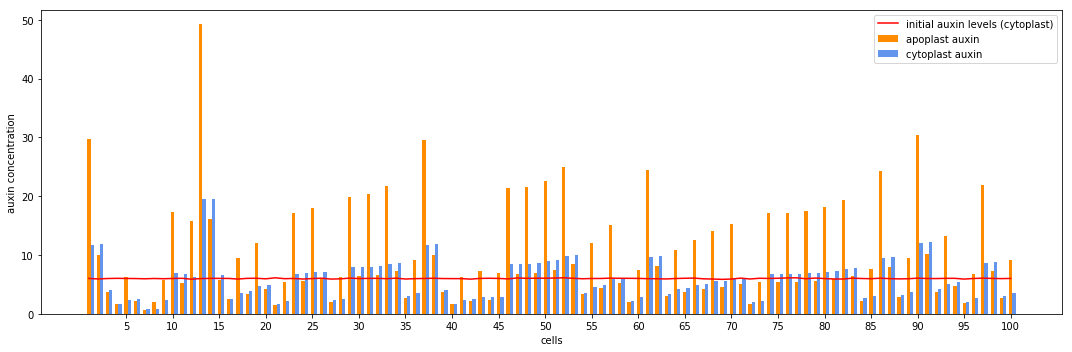

In [8]:
# concentration of auxin in cytosol and apoplast over all cells
# lines: show curve plot; bars: show barplot
def apo(lines,bars):
    
    fig=plt.figure(figsize=(15,5))
    ax=plt.subplot(111)
    ind=np.arange(1,n+1)
    bw=0.35
    
    plt.plot(range(1,n+1),R[0,:n],color="r",label="initial auxin levels (cytoplast)")
    if bars:
        ax.bar(ind,R[-1,n:2*n],bw,label="apoplast auxin",color="darkorange")
        ax.bar(ind+bw,R[-1,:n],bw,label="cytoplast auxin",color="cornflowerblue")
    if lines:
        ax.plot(ind,R[-1,n:2*n],"darkorange")
        ax.plot(ind+bw,R[-1,:n],"cornflowerblue")
        
    ax.set_xticks([int(ind[i-1]+bw/2) for i in range(1,n+1) if i%5==0])
    plt.xlabel("cells")
    plt.ylabel("auxin concentration")
    plt.legend()
    fig.tight_layout()
    plt.show()

apo(lines=0,bars=1)

max: 15.228
min: 1.412


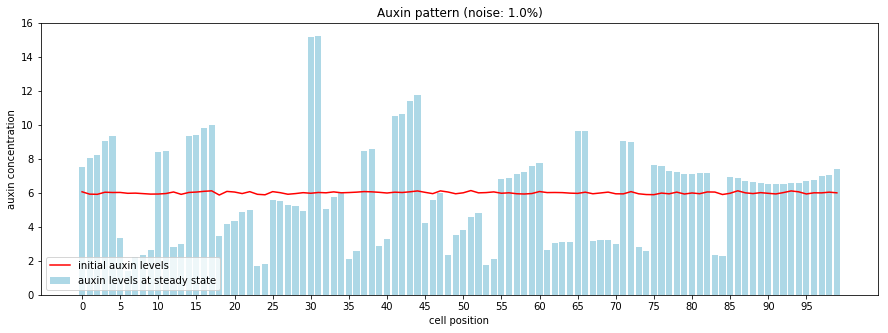

In [17]:
# barplot of auxin levels over all cells without apoplast (base: show initial auxin distribution)
def pattern(base):

    print("max:","{0:.3f}".format(max(R[-1,:n])))
    print("min:","{0:.3f}".format(min(R[-1,:n])))
    
    fig=plt.figure(figsize=(15,5))
    
    plt.bar(range(n),R[-1,:n],color="lightblue",label="auxin levels at steady state")
    if base: plt.plot(range(n),start[:n],"r",label="initial auxin levels")
        
    plt.ylabel("auxin concentration")
    plt.xlabel("cell position")
    if n>50: plt.xticks(range(0,n,5))
    else: plt.xticks(range(1,n+1))
    plt.title("Auxin pattern (noise: {}%)".format(noise*100))
    plt.legend(loc="lower left")
    plt.show()
    
pattern(base=1)

In [ ]:
# progress of integration (timestep/total time)
def progress(t,T):
    prog="\r{0:.4f}%".format(t/T*100)
    sys.stdout.write(prog+" "*(25-len(prog)))

### Create animated plot

In [19]:
import numpy as np
import pylab as plt### Create animated plot
from matplotlib import animation
from IPython.display import HTML

In [49]:
fig=plt.figure(figsize=(15,5))
ax=plt.axes()
ax2=plt.twinx()

ax.set_xlabel("cells")
ax.set_ylabel("Auxin concentration")
ax.set_ylim((0,20))
ax2.set_ylabel("PIN concentration")
ax2.set_ylim((0,100))

barA = ax.bar(np.arange(n)-.2,R[0,:n],width=0.4,align="center",color="cornflowerblue",label="cytoplast")
barB = ax.bar(np.arange(n)+.2,R[0,n:2*n],width=0.4,align="center",color="darkorange",label="apoplast")
pl, = ax2.plot(np.arange(n)-.2,R[0,2*n:3*n],color="green",label="PIN left")
pr, = ax2.plot(np.arange(n)-.2,R[0,3*n:],color="red",label="PIN right")

ax.legend()

In [40]:
def animate(i,pin=0):
    for j in range(n):
        [barA[j].set_height(R[i,j]) for j in range(n)]
        [barB[j].set_height(R[i,j+n]) for j in range(n)]
    if pin:
        pl.set_data(range(n),R[i,2*n:3*n])
        pr.set_data(range(n),R[i,3*n:])
    ax.set_title("t="+str(i))
    return barA,barB,pl,pr

In [41]:
ani=animation.FuncAnimation(fig,animate,frames=100)

In [42]:
HTML(ani.to_html5_video())